In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
import xarray as xr
from tensorflow.keras import models, layers, regularizers,optimizers
# from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import to_categorical
from scipy.io import savemat
import h5py
import matplotlib.pyplot as plt
import pygmt
from sklearn.model_selection import train_test_split


In [2]:
data = pygmt.select(region="-15/5/-4/4",data="../data/guinea.txtok")
# chose = data.sample(n=5000)
print(data.shape)
control, check = train_test_split(data, train_size=0.8, test_size=0.2, random_state=17)
# control = data.sample(frac=0.8)
print(control.shape)

print(check.shape)
check

(117814, 3)
(94251, 3)
(23563, 3)


,0,1,2
50096,-2.78888,3.69997,-2190.0
80040,-12.12591,-2.83756,-3874.5
34344,1.30423,0.85671,-4757.0
70308,-3.83350,0.99979,-5124.1
28554,2.52500,2.57000,-4335.0
...,...,...,...
27325,-13.58730,-1.25460,-3121.0
37831,-0.32567,3.44108,-4762.0
53336,-3.13593,3.22243,-4875.0
64845,-11.34935,2.57271,-4564.0


In [3]:
free = pygmt.grdcut(grid="../GeoModel/Free_Air_Gravity_Anomalies/Free_Air_Gravity_Anomalies.nc", region="-15.5/5.5/-4.5/4.5")
free_15s=pygmt.grdsample(grid=free,spacing="15s")

In [4]:
vgg = pygmt.grdcut(grid="../GeoModel/Vertical_Gravity_Gradient/Vertical_Gravity_Gradient.nc", region="-15.5/5.5/-4.5/4.5")
vgg_15s=pygmt.grdsample(grid=vgg,spacing="15s")

In [5]:
nvd = pygmt.grdcut(grid="../data/north_32.1.nc", region="-15.5/5.5/-4.5/4.5")
nvd_15s=pygmt.grdsample(grid=nvd,spacing="15s")

In [6]:
evd = pygmt.grdcut(grid="../data/east_32.1.nc", region="-15.5/5.5/-4.5/4.5")
evd_15s=pygmt.grdsample(grid=evd,spacing="15s")

In [7]:
control_depth_free=pygmt.grdtrack(points=control.values,grid=free_15s,no_skip=True)
y_train1 = control_depth_free.values[:,0:3] # lon lat depth
x_train1 = control_depth_free.values[:,3] # gravity
x_train1 = np.reshape(x_train1, (len(x_train1), 1))

x_lat = np.reshape(y_train1[:, 1], (len(y_train1[:, 1]), 1))
x_lon = np.reshape(y_train1[:, 0], (len(y_train1[:, 0]), 1))

rou=1.0
d=-8000
control_short=(y_train1[:,2]-d)*2*3.1415*6.67259*(10**-8)*rou*100000 # short wavelength gravity ano
control_short = np.reshape(control_short, (len(control_short), 1))
control_long=x_train1-control_short
short=np.concatenate((y_train1[:,0:2],control_short),axis=1)
long=np.concatenate((y_train1[:,0:2],control_long),axis=1)
reg="-15.5/5.5/-4.5/4.5"
pygmt.surface(region=reg, spacing="15s",outgrid="long.grd",data=long)
temp=pygmt.grd2xyz(grid=free_15s)
pygmt.surface(region=reg, spacing="15s",outgrid="free3.grd",data=temp)
long0 = xr.open_dataset("long.grd")
free0 = xr.open_dataset("free3.grd")
short0 = free0-long0
short0.to_netcdf("short.grd")

surface [WARNING]: 28717 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.
surface [WARNING]: 6043199 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


In [8]:
x = free_15s.isel(lat=slice(1,2,3),lon=slice(1,2,3))
x.values

array([[-5.841362]], dtype=float32)

In [9]:
con_lat_index=short0.indexes["lat"].get_indexer(control.values[:,1],method="nearest")
con_lon_index=short0.indexes["lon"].get_indexer(control.values[:,0],method="nearest")
con_lat_index

array([ 335, 1956,  321, ..., 1389, 1662, 1889])

In [10]:
%%time
shape = np.array([4,4,1])
x = 2
temp2 = []
for i in range(len(control[0])):
#     free_temp = free_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
    short_temp = short0.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
#     vgg_temp = vgg_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
#     nvd_temp = nvd_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
#     evd_temp = evd_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
# #     mae_temp = mae_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
    lat1 = short0.lat[con_lat_index[i]-x:con_lat_index[i]+x]
    lon1 = short0.lon[con_lon_index[i]-x:con_lon_index[i]+x]
    LAT,LON = np.meshgrid(lat1,lon1)
    # print(LON.shape)
    temp1 = np.concatenate([np.reshape(short_temp.z.values,shape),np.reshape(LON,shape),np.reshape(LAT,shape)],axis=2)
    temp2.append(temp1)
temp2 = np.array(temp2)
temp2.shape

CPU times: user 1min 8s, sys: 576 ms, total: 1min 9s
Wall time: 1min 8s


(94251, 4, 4, 3)

In [11]:
m,n,k,p = np.shape(temp2)
scalerlon = MinMaxScaler().fit(np.reshape(temp2[:,:,:,1],(m*n*k,1)))
scalerlat = MinMaxScaler().fit(np.reshape(temp2[:,:,:,2],(m*n*k,1)))
# scalerfree = MinMaxScaler().fit(np.reshape(temp2[:,:,:,6],(m*n*k,1)))
scalershort = MinMaxScaler().fit(np.reshape(temp2[:,:,:,0],(m*n*k,1)))
# scalervgg = MinMaxScaler().fit(np.reshape(temp2[:,:,:,1],(m*n*k,1)))
# scalernvd = MinMaxScaler().fit(np.reshape(temp2[:,:,:,2],(m*n*k,1)))
# scalerevd = MinMaxScaler().fit(np.reshape(temp2[:,:,:,3],(m*n*k,1)))
# scalermae = MinMaxScaler().fit(np.reshape(temp2[:,:,:,6],(m*n*k,1)))
scalerdepth = MinMaxScaler().fit(np.reshape(control.values[:,2],(-1,1)))
lon_train = scalerlon.transform(np.reshape(temp2[:,:,:,1],(m*n*k,1)))
lat_train = scalerlat.transform(np.reshape(temp2[:,:,:,2],(m*n*k,1)))
# free_train = scalerfree.transform(np.reshape(temp2[:,:,:,6],(m*n*k,1)))
short_train = scalershort.transform(np.reshape(temp2[:,:,:,0],(m*n*k,1)))
# vgg_train = scalervgg.transform(np.reshape(temp2[:,:,:,1],(m*n*k,1)))
# nvd_train = scalernvd.transform(np.reshape(temp2[:,:,:,2],(m*n*k,1)))
# evd_train = scalerevd.transform(np.reshape(temp2[:,:,:,3],(m*n*k,1)))
# mae_train = scalerevd.transform(np.reshape(temp2[:,:,:,6],(m*n*k,1)))
x_train = np.reshape(np.concatenate([short_train,lon_train,lat_train],axis=1),(m,n,k,p))
y_train = scalerdepth.transform(np.reshape(control.values[:,2],(-1,1)))

# print(x_train[111,:,:,2])
print(x_train.shape)
print(y_train.shape)

(94251, 4, 4, 3)
(94251, 1)


In [12]:
# 打乱数据顺序
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape,y_train.shape)

(94251, 4, 4, 3) (94251, 1)


In [13]:
model = models.Sequential()
model.add(layers.Conv2D(64,(3,3), input_shape=(4,4,3),activation='relu',padding="same", name="conv1",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3,3),activation='relu',padding="same", name="conv2",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Conv2D(256, (3,3),activation='relu',padding="same", name="conv3",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3),activation='relu',padding="same", name="conv5",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1))

2022-10-02 08:53:13.450435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 08:53:14.210617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9045 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [14]:
opt = optimizers.Adam(learning_rate=0.001)
Patience = 3
early_stop = EarlyStopping(monitor='loss', mode='min', patience=Patience)
reduce_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.5, patience=Patience, mode='min',
                         min_delta=0.001, min_lr=1e-7, verbose=1)
model.compile(
        optimizer=opt,
        loss='mse',metrics='RootMeanSquaredError')
# tf.config.experimental_run_functions_eagerly(True)
model.fit(x_train, y_train, epochs=40
                    , batch_size=128
                    ,callbacks=reduce_lr)

Epoch 1/40


2022-10-02 08:53:16.321011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


737/737 [==============================] - 9s 9ms/step - loss: 0.0740 - root_mean_squared_error: 0.2721 - lr: 0.0010
Epoch 2/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - lr: 0.0010
Epoch 3/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - lr: 0.0010
Epoch 4/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - lr: 0.0010
Epoch 5/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - lr: 0.0010
Epoch 6/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - lr: 0.0010
Epoch 7/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - lr: 0.0010
Epoch 8/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 

In [15]:
che_lat_index=short0.indexes["lat"].get_indexer(check.values[:, 1],method="nearest")
che_lon_index=short0.indexes["lon"].get_indexer(check.values[:, 0],method="nearest")

In [16]:
temp_test = []
for i in range(len(check)):
#     free_temp_test = free_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
    short_temp_test = short0.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
#     vgg_temp_test = vgg_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
#     nvd_temp_test = nvd_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
#     evd_temp_test = evd_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
#     mae_temp_test = mae_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x,1),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x,1))
    lat_temp_test = short0.lat[che_lat_index[i]-x:che_lat_index[i]+x]
    lon_temp_test = short0.lon[che_lon_index[i]-x:che_lon_index[i]+x]
    LAT_temp_test,LON_temp_test = np.meshgrid(lat_temp_test,lon_temp_test)
    # print(LON.shape)
    temp3 = np.concatenate([np.reshape(short_temp_test.z.values,shape),np.reshape(LON_temp_test,shape),np.reshape(LAT_temp_test,shape)],axis=2)
    temp_test.append(temp3)
temp_test = np.array(temp_test)
temp_test.shape

(23563, 4, 4, 3)

In [17]:
mt,nt,kt,pt = np.shape(temp_test)
# scalerlon_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,4],(mt*nt*kt,1)))
# scalerlat_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,5],(mt*nt*kt,1)))
# scalerfree_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
# scalervgg_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
# scalernvd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
# scalerevd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,3],(mt*nt*kt,1)))
# scalerdepth_test = MinMaxScaler().fit(np.reshape(check.values[:,2],(-1,1)))
lon_test = scalerlon.transform(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
lat_test = scalerlat.transform(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
# free_test = scalerfree.transform(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
short_test = scalershort.transform(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
# vgg_test = scalervgg.transform(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
# nvd_test = scalernvd.transform(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
# evd_test = scalerevd.transform(np.reshape(temp_test[:,:,:,3],(mt*nt*kt,1)))
# mae_test = scalermae.transform(np.reshape(temp_test[:,:,:,6],(mt*nt*kt,1)))
x_test = np.reshape(np.concatenate([short_test,lon_test,lat_test],axis=1),(mt,nt,kt,pt))
y_test = scalerdepth.transform(np.reshape(check.values[:,2],(-1,1)))
print(x_test.shape)
print(y_test.shape)

(23563, 4, 4, 3)
(23563, 1)


In [18]:
model.evaluate(x_test, y_test, batch_size=64)
model.save('../model/Africa_cnn9.h5')
pre = model.predict(x_test, batch_size=64)
pre_raw = scalerdepth.inverse_transform(pre)

369/369 [==============================] - 1s 3ms/step


In [19]:
true = np.reshape(check.values[:,2],(-1,1))
m = np.abs(np.mean((true-pre_raw)))
std = np.std(true-pre_raw)
print("m:",m)
print("STD:",std)

m: 33.46166646123889
STD: 66.30583749981353


In [20]:
check.values[:,2]-pre_raw

array([[ 1.75321045e+02, -1.50917896e+03, -2.39167896e+03, ...,
        -2.50967896e+03, -2.19867896e+03, -1.88467896e+03],
       [ 1.73914746e+03,  5.46474609e+01, -8.27852539e+02, ...,
        -9.45852539e+02, -6.34852539e+02, -3.20852539e+02],
       [ 2.56453467e+03,  8.80034668e+02, -2.46533203e+00, ...,
        -1.20465332e+02,  1.90534668e+02,  5.04534668e+02],
       ...,
       [ 2.68241406e+03,  9.97914062e+02,  1.15414062e+02, ...,
        -2.58593750e+00,  3.08414062e+02,  6.22414062e+02],
       [ 2.38125684e+03,  6.96756836e+02, -1.85743164e+02, ...,
        -3.03743164e+02,  7.25683594e+00,  3.21256836e+02],
       [ 2.07757080e+03,  3.93070801e+02, -4.89429199e+02, ...,
        -6.07429199e+02, -2.96429199e+02,  1.75708008e+01]])

In [21]:
%%time

# free_all = np.array(free_15s.data,dtype=float)
short_all = short0.z.values
# vgg_all = vgg_15s.values
# evd_all = evd_15s.values
# nvd_all = nvd_15s.values
lat_all = short0.lat.values
lon_all = short0.lon.values

temp_pre = []
# lonlat=[]
for i in np.arange(2,len(lat_all),4):
    for j in np.arange(2,len(lon_all),4):
#         free_temp_pre = free_all[i-x:i+x,j-x:j+x]
        short_temp_pre = short_all[i-x:i+x,j-x:j+x]
#         vgg_temp_pre = vgg_all[i-x:i+x,j-x:j+x]
#         nvd_temp_pre = nvd_all[i-x:i+x,j-x:j+x]
#         evd_temp_pre = evd_all[i-x:i+x,j-x:j+x]
        lat_temp_pre = lat_all[i-x:i+x]
        lon_temp_pre = lon_all[j-x:j+x]
        LAT_temp_pre,LON_temp_pre = np.meshgrid(lat_temp_pre,lon_temp_pre)
        # print(LON.shape)
        temp4 = np.concatenate([np.reshape(short_temp_pre,shape),np.reshape(LON_temp_pre,shape),np.reshape(LAT_temp_pre,shape)],axis=2)
#         lonlat.append(np.concatenate((lat_temp_pre,lon_temp_pre),axis=1)) 
        temp_pre.append(temp4)
temp_pre = np.array(temp_pre)


CPU times: user 31.7 s, sys: 569 ms, total: 32.2 s
Wall time: 32.1 s


In [22]:
a,b,c,d = np.shape(temp_pre)
# scalerlon_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,4],(mt*nt*kt,1)))
# scalerlat_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,5],(mt*nt*kt,1)))
# scalerfree_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
# scalervgg_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
# scalernvd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
# scalerevd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,3],(mt*nt*kt,1)))
# scalerdepth_test = MinMaxScaler().fit(np.reshape(check.values[:,2],(-1,1)))
lon_pre = scalerlon.transform(np.reshape(temp_pre[:,:,:,1],(a*b*c,1)))
lat_pre = scalerlat.transform(np.reshape(temp_pre[:,:,:,1],(a*b*c,1)))
# free_pre = scalerfree.transform(np.reshape(temp_pre[:,:,:,0],(a*b*c,1)))
short_pre = scalershort.transform(np.reshape(temp_pre[:,:,:,0],(a*b*c,1)))
# vgg_pre = scalervgg.transform(np.reshape(temp_pre[:,:,:,1],(a*b*c,1)))
# nvd_pre = scalernvd.transform(np.reshape(temp_pre[:,:,:,2],(a*b*c,1)))
# evd_pre = scalerevd.transform(np.reshape(temp_pre[:,:,:,3],(a*b*c,1)))
# mae_test = scalermae.transform(np.reshape(temp_test[:,:,:,6],(mt*nt*kt,1)))
x_pre = np.reshape(np.concatenate([short_pre,lon_pre,lat_pre],axis=1),(a,b,c,d))


In [23]:
pre_depth = model.predict(x_pre,batch_size=120)
grid_depth = scalerdepth.inverse_transform(pre_depth)


5670/5670 [==============================] - 18s 3ms/step


In [24]:
lat_grid = []
lon_grid = []
for i in np.arange(2,len(short0.lat),4):
    for j in np.arange(2,len(short0.lon),4):
        lat_grid.append(lat_all[i])
        lon_grid.append(lon_all[j])
lat_huatu = np.array(lat_grid)
lon_huatu = np.array(lon_grid)

depth_cnn=np.concatenate((np.reshape(lon_huatu,(-1,1)),np.reshape(lat_huatu,(-1,1)), grid_depth), axis=1)

surface [WARNING]: 185796 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


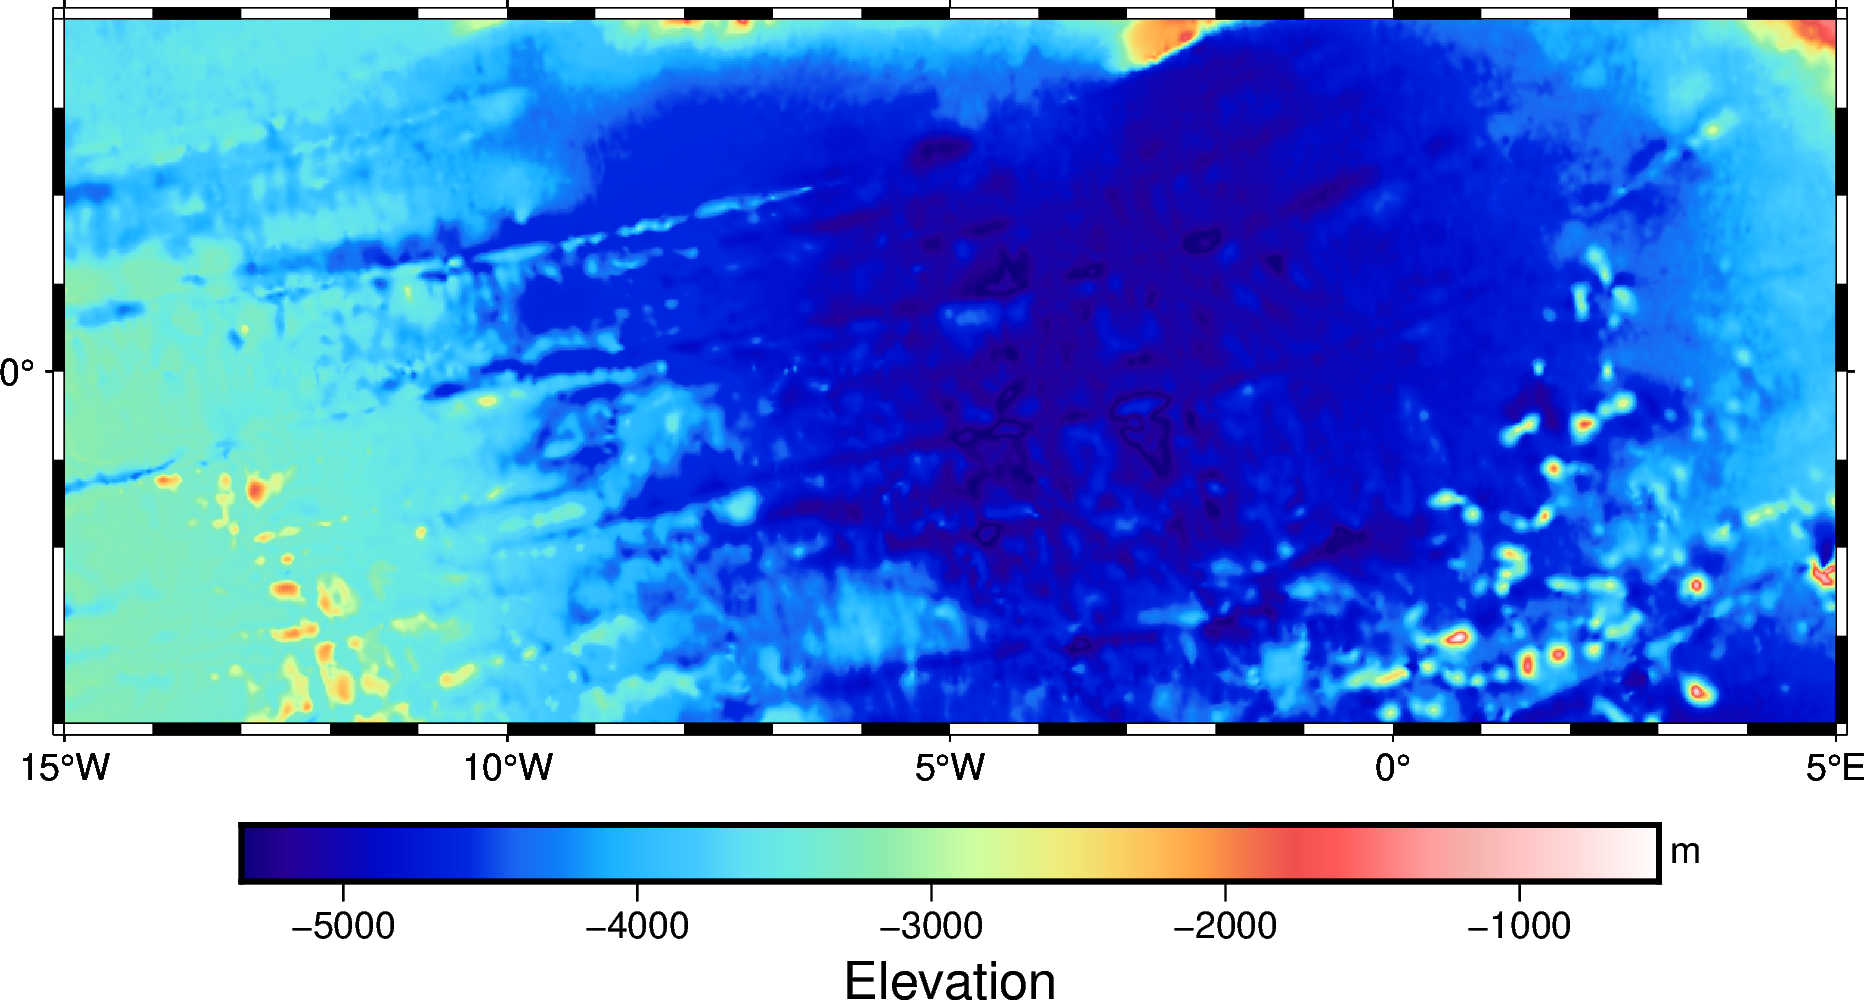

In [25]:
fig = pygmt.Figure()
pygmt.surface(region="-15/5/-4/4", spacing="1m",outgrid="depth_cnn3.grd",data=depth_cnn)
fig.basemap(region="-15/5/-4/4", projection="M15c", frame="afg")
fig.coast(borders=["1/0.5p,black", "2/0.5p,red", "3/0.5p,blue"], land="gray")
fig.grdimage(
    grid="depth_cnn3.grd",
    cmap="haxby",
    frame=True,
)
fig.colorbar(frame=["a", "x+lElevation", "y+lm"])

fig.show(width="1000")


In [26]:
depth_case = xr.open_dataset("depth_cnn3.grd")
depth_case.to_netcdf("../result/depth_case8.nc")